In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import statsmodels.api as sm
import scipy
import matplotlib as mpl
import seaborn as sns


%matplotlib widget
plt.style.use('presentation.mplstyle')
width = 1.6
height = 1

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure5\PlotsCorentin"


In [3]:
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

In [6]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)


In [7]:
time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)

C:\Users\coren\AppData\Local\Temp\ipykernel_13844\1812542758.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)


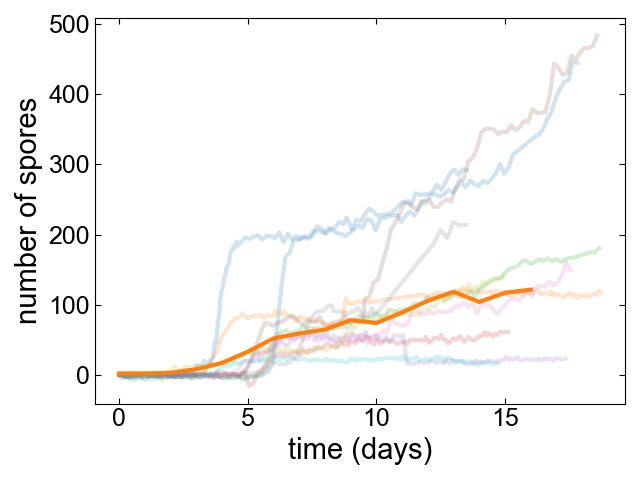

In [8]:
fig,ax = plt.subplots()
y = "num_spores"

for unique_id in time_plate_info['unique_id'].unique():
    select = time_plate_info.loc[time_plate_info['time_since_begin_h']<450]
    # select = time_plate_info.loc[time_plate_info['time_since_begin_h']<900]
    
    select = select.loc[select['unique_id']==unique_id]
    select = select.loc[select[y]>0]
    select = select.sort_values('time_since_begin_h')
    if len(select)>0:
        ax.plot(select["time_since_begin_h"]/24,select[y]-select[y].iloc[0],label=unique_id,alpha = 0.2)

mini = time_plate_info.groupby('unique_id')[y].min()
maxi = time_plate_info.groupby('unique_id')[y].max()

table_group = time_plate_info.set_index('unique_id').copy()
table_group['mini']= mini
table_group['spore_reduced'] = table_group[y]-table_group['mini']
table_group['maxi']= maxi
table_group = table_group.loc[table_group['maxi']>0]
data = table_group.groupby('day')["spore_reduced"].median()
data = data.loc[data.index<17]

ax.plot(data.index,data)
# ax.set_yscale('log')
# ax.legend()
ax.set_xlabel('time (days)')
ax.set_ylabel('number of spores')
plt.tight_layout()

In [9]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"
paths = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table = pd.DataFrame()
num_day = 3
for path in paths:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table = pd.concat([table,new])
table["days"] = table["time_since_crossing"] / pd.Timedelta(days=1)
table["3days"] = (table["time_since_crossing"] / pd.Timedelta(days=num_day)).astype(int)
table["days_since_first_image"] = table["days"] - table.groupby("unique_id")[
    "days"
].transform("min")
table["abs_speed-"] = -table["speed-"]

table["speed"] = table[["speed+", "abs_speed-"]].max(1)
grouping = 1
table["lengthdm"] = (np.log2((table["tot_length"]))/grouping).astype(int) * grouping
table["log_tot_num_spores"] = (np.log2((table["tot_num_spore"]))/grouping).astype(int)* grouping
table["log_tot_num_spores"] = (np.log10((table["tot_num_spore"])))

grouping = 1
funtype = 1
time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)
# table['spore_volume_group'] = (table["spore_volume"]/1e8).astype(int)/10

In [10]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"

path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['csv_id'] = path
    
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            table_speeds = pd.concat([table_speeds,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))
table_speeds["abs_speed"] = abs(table_speeds['speed']) 


In [11]:
table_speeds = table_speeds.set_index(['csv_id','kymo_id'])
table = table.set_index(['csv_id','kymo_id'])
speedp = table_speeds.loc[table_speeds['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed+'] = mean_speed
speedp = table_speeds.loc[table_speeds['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed-'] = mean_speed
table["mean_speed+"] = table["mean_speed+"].fillna(table["speed+"])
table["mean_speed-"] = table["mean_speed-"].fillna(table["speed-"])
table["ratio"] = -table["mean_speed+"]/table["mean_speed-"]
table["diff"] = table["mean_speed+"]+table["mean_speed-"]



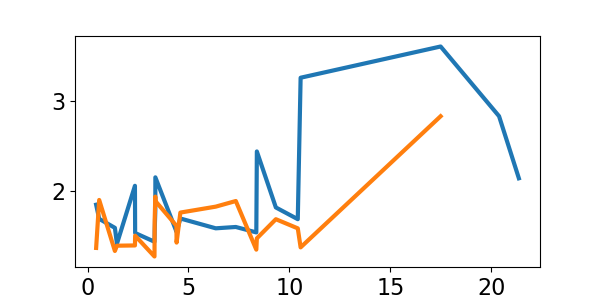

In [31]:
fig, ax = plt.subplots(figsize = (6,3))
table['ratio'] = table['speed+']/table['mean_speed+']
mean = table.groupby('days')['ratio'].mean()
# ax.scatter(table['days'],table['speed+']/table['mean_speed+'])
ax.plot(mean.index,mean)
table['ratio'] = table['speed-']/table['mean_speed-']
mean = table.groupby('days')['ratio'].mean()
# ax.scatter(table['days'],table['speed+']/table['mean_speed+'])
ax.plot(mean.index,mean)
# ax.set_ylim(-5,5)

In [12]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = "grey", alpha = 0.01)
        return(a)
    return(statistic)

In [13]:
table_speeds.to_csv(os.path.join(path_figure,'all_speeds.csv'))
table.to_csv(os.path.join(path_figure,'max_speeds.csv'))

2024-01-30 14:32:18,054-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2024-01-30 14:32:18,190-[INFO]- fontTools.subset:2815 -> maxp pruned
2024-01-30 14:32:18,194-[INFO]- fontTools.subset:2799 -> LTSH dropped
2024-01-30 14:32:18,199-[INFO]- fontTools.subset:2815 -> cmap pruned
2024-01-30 14:32:18,210-[INFO]- fontTools.subset:2799 -> kern dropped
2024-01-30 14:32:18,211-[INFO]- fontTools.subset:2815 -> post pruned
2024-01-30 14:32:18,215-[INFO]- fontTools.subset:2799 -> PCLT dropped
2024-01-30 14:32:18,265-[INFO]- fontTools.subset:2815 -> GPOS pruned
2024-01-30 14:32:18,292-[INFO]- fontTools.subset:2815 -> GSUB pruned
2024-01-30 14:32:18,293-[INFO]- fontTools.subset:2799 -> JSTF dropped
2024-01-30 14:32:18,297-[INFO]- fontTools.subset:2799 -> DSIG dropped
2024-01-30 14:32:18,300-[INFO]- fontTools.subset:2815 -> name pruned
2024-01-30 14:32:18,356-[INFO]- fontTools.subset:2815 

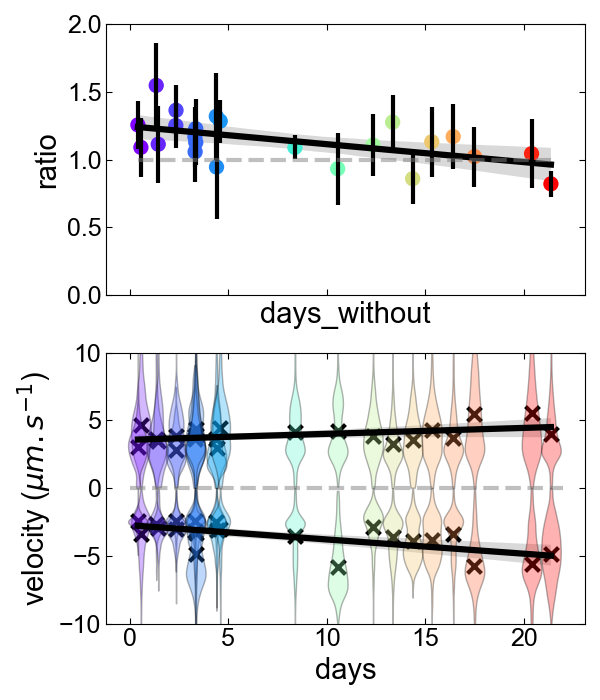

In [14]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
f, (ax, ax1) = plt.subplots(2, 1, sharex=True,figsize=(6,7))

cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*6
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*6

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
select = table.loc[abs(table["ratio"]).between(0,10)]


n_resamples = 1000
selectp = select

mean = selectp.groupby("days_without")["ratio"].median()
std = selectp.groupby("days_without")["ratio"].std()
count = selectp.groupby("days_without")["ratio"].count()
data = np.array((mean.index,mean))
x,y = mean.index,mean
# ax.scatter(select["days_without"],select['ratio'])
sns.regplot(x = x,
    y = y,ax=ax,scatter=False, color="black")
# statistic = make_stat(x,ax)
# ci = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).confidence_interval
# X = sm.add_constant(x, prepend=False)
# model = sm.OLS(y,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# print(a,ci)
# ax.plot(x,np.array(x)*a+b,color = "black")
ax.scatter(mean.index, mean,c=mean.index,cmap = "rainbow")
ax.errorbar(mean.index, mean,yerr= 2*std/np.sqrt(count),fmt = 'None',color="black")
ax.plot(mean.index, mean*0+1,color="grey",alpha = 0.5,linestyle = '--')

# for tot_num_spores in select["days_without"].unique():
#     subselect = select.loc[select["days_without"]==tot_num_spores]
#     day = subselect["days_without"].iloc[0]
#     parts = ax.violinplot(subselect["ratio"],[day]
#                           ,widths = 1,showextrema=False)
#     for pc in parts['bodies']:
#         pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
#         pc.set_edgecolor('black')


# ax.set_xlabel("days")
ax.set_ylabel("ratio")
ax.set_ylim(0,2)
cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*6
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*6

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
# select = table_speeds.loc[table_speeds["abs_speed"].between(-50, 50)]
select = table_speeds.loc[abs(table_speeds["abs_speed"])>0]

# select = table_speeds.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
select1 = table_speeds.loc[table_speeds["speed"]>0]
select2 = table_speeds.loc[table_speeds["speed"]<0]
for select in [select1,select2]:

    selectp = select

    mean = selectp.groupby("days_without")["speed"].mean()
    std = selectp.groupby("days_without")["speed"].std()
    count = selectp.groupby("days_without")["speed"].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
    sns.regplot(x = x,
        y = y,ax=ax1,scatter=False, color="black")
    # statistic = make_stat(x,ax1)
    # std = scipy.stats.bootstrap(data,statistic,
    #                             vectorized = False,
    #                             method="basic",
    #                             n_resamples = n_resamples,
    #                             paired= True).confidence_interval
    # X = sm.add_constant(x, prepend=False)
    # model = sm.OLS(y,X)
    # res = model.fit()
    # a,b = res.params[0],res.params[1]
    # print(a,std)
    # ax1.plot(x,np.array(x)*a+b,color = "black")
    # ax.plot(mean.index, mean,color="blue")
    ax1.scatter(mean.index, mean,color="black",marker="x")
    for tot_num_spores in select["days_without"].unique():
        subselect = select.loc[select["days_without"]==tot_num_spores]
        day = subselect["days_without"].iloc[0]
        parts = ax1.violinplot(subselect["speed"],[day]
                              ,widths = 1,showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
            pc.set_edgecolor('black')
    # err =  2*std / np.sqrt(count)
# ax.scatter(table['days_without'],table['speed+'],marker='+',s = 1,alpha = 0.2)
# ax.scatter(table['days_without'],table['speed-'],marker='+',s = 1,alpha = 0.2)

ax1.set_xlabel("days")
ax1.set_ylabel("velocity ($\mu m.s^{-1}$)")
plt.tight_layout()
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
# labels = [label if label%10==0 else '' for label in labels]

# ax.set_xticklabels(labels)

# path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure4"
# plt.savefig(os.path.join(path_figure,'Figure4E_meanabsspeed_spore.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4E_meanabsspeed_spore.EPS'))

plt.savefig(os.path.join(path_figure,'meanspeed_day.png'))
# plt.savefig(os.path.join(path_figure,'meanspeed_day.svg'))

ax1.set_ylim(-10,10)
ax1.hlines(0,0,22,color='grey',linestyle='--',alpha = 0.5)

plt.savefig(os.path.join(path_figure,'meanspeed_day_uncropped.png'))
plt.tight_layout()
plt.savefig(os.path.join(path_figure,'5C.png'))
plt.savefig(os.path.join(path_figure,'5C.EPS'))




2024-01-30 14:32:20,588-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2024-01-30 14:32:20,698-[INFO]- fontTools.subset:2815 -> maxp pruned
2024-01-30 14:32:20,699-[INFO]- fontTools.subset:2799 -> LTSH dropped
2024-01-30 14:32:20,701-[INFO]- fontTools.subset:2815 -> cmap pruned
2024-01-30 14:32:20,703-[INFO]- fontTools.subset:2799 -> kern dropped
2024-01-30 14:32:20,705-[INFO]- fontTools.subset:2815 -> post pruned
2024-01-30 14:32:20,707-[INFO]- fontTools.subset:2799 -> PCLT dropped
2024-01-30 14:32:20,759-[INFO]- fontTools.subset:2815 -> GPOS pruned
2024-01-30 14:32:20,791-[INFO]- fontTools.subset:2815 -> GSUB pruned
2024-01-30 14:32:20,792-[INFO]- fontTools.subset:2799 -> JSTF dropped
2024-01-30 14:32:20,794-[INFO]- fontTools.subset:2799 -> DSIG dropped
2024-01-30 14:32:20,797-[INFO]- fontTools.subset:2815 -> name pruned
2024-01-30 14:32:20,836-[INFO]- fontTools.subset:2815 

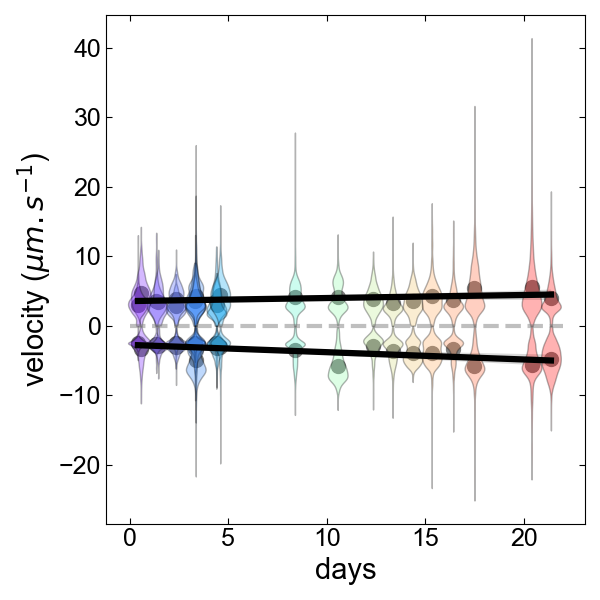

In [15]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots(figsize = (6,6))
# ax2 = ax.twinx()
cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*6
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*6

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
# select = table_speeds.loc[table_speeds["abs_speed"].between(-50, 50)]
select = table_speeds.loc[abs(table_speeds["abs_speed"])>0]

# select = table_speeds.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
select1 = table_speeds.loc[table_speeds["speed"]>0]
select2 = table_speeds.loc[table_speeds["speed"]<0]
n_resamples = 1000
for select in [select1,select2]:

    selectp = select

    mean = selectp.groupby("days_without")["speed"].mean()
    std = selectp.groupby("days_without")["speed"].std()
    count = selectp.groupby("days_without")["speed"].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
    sns.regplot(x = x,
        y = y,ax=ax,scatter=False, color="black")
    # statistic = make_stat(x,ax)
    # std = scipy.stats.bootstrap(data,statistic,
    #                             vectorized = False,
    #                             method="basic",
    #                             n_resamples = n_resamples,
    #                             paired= True).confidence_interval
    # X = sm.add_constant(x, prepend=False)
    # model = sm.OLS(y,X)
    # res = model.fit()
    # a,b = res.params[0],res.params[1]
    # print(a,std)
    # ax.plot(x,np.array(x)*a+b,color = "black")
    # ax.plot(mean.index, mean,color="blue")
    ax.scatter(mean.index, mean,color="grey")
    for tot_num_spores in select["days_without"].unique():
        subselect = select.loc[select["days_without"]==tot_num_spores]
        day = subselect["days_without"].iloc[0]
        parts = ax.violinplot(subselect["speed"],[day]
                              ,widths = 1,showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
            pc.set_edgecolor('black')
    # err =  2*std / np.sqrt(count)
# ax.scatter(table['days_without'],table['speed+'],marker='+',s = 1,alpha = 0.2)
# ax.scatter(table['days_without'],table['speed-'],marker='+',s = 1,alpha = 0.2)

ax.set_xlabel("days")
ax.set_ylabel("velocity ($\mu m.s^{-1}$)")
ax.hlines(0,0,22,color='grey',linestyle='--',alpha = 0.5)

plt.tight_layout()
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
# labels = [label if label%10==0 else '' for label in labels]

# ax.set_xticklabels(labels)

# path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure4"
# plt.savefig(os.path.join(path_figure,'Figure4E_meanabsspeed_spore.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4E_meanabsspeed_spore.EPS'))

plt.savefig(os.path.join(path_figure,'5B.png'))
plt.savefig(os.path.join(path_figure,'5B.EPS'))

# plt.savefig(os.path.join(path_figure,'meanspeed_day.svg'))

# ax.set_ylim(-10,10)
# plt.savefig(os.path.join(path_figure,'meanspeed_day_uncropped.png'))
# plt.savefig(os.path.join(path_figure,'meanspeed_day_uncropped.svg'))
# ax.set_yscale('symlog')
# plt.savefig(os.path.join(path_figure,'meanspeed_day.EPS'))
# plt.savefig(os.path.join(path_figure,'log_mean_max.png'))


C:\Users\coren\AppData\Local\Temp\ipykernel_20352\1890549690.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


[Text(-0.5, 0, '0'),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, '10'),
 Text(1.5, 0, ''),
 Text(2.0, 0, '100'),
 Text(2.5, 0, ''),
 Text(3.0, 0, '1000'),
 Text(3.5, 0, '')]

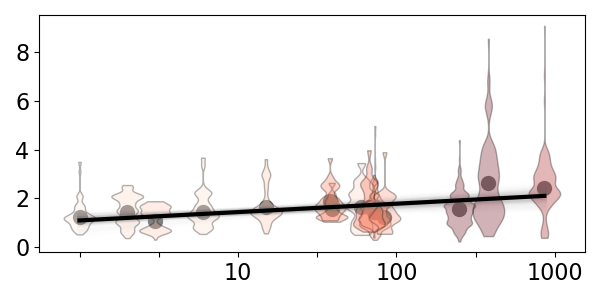

In [313]:
import ast
n_resamples=100

time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots(figsize = (6,3))
# ax2 = ax.twinx()
cmap = mpl.cm.get_cmap("Reds")

# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
select = table_speeds.loc[table_speeds["speed"].between(-50, 50)]
select = table_speeds.loc[abs(table_speeds["count+"])>10]

# select = table_speeds.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
selectp = table_speeds.loc[table_speeds["speed"]>0]

mean = selectp.groupby("log_tot_num_spores")['std_speed+'].mean()
std = selectp.groupby("log_tot_num_spores")['std_speed+'].std()
count = selectp.groupby("log_tot_num_spores")['std_speed+'].count()
# ax.plot(2**mean.index, mean,color="blue")
# ax.scatter(2**mean.index, mean,color="blue")
# # for tot_num_spores in select["log_tot_num_spores"].unique():
# #     subselect = select.loc[select["log_tot_num_spores"]==tot_num_spores]
# #     ax.violinplot(subselect["speed"],[2**subselect["log_tot_num_spores"].iloc[0]],widths = 100)
# err =  2*std / np.sqrt(count)
# ax.fill_between(2**mean.index, mean-err, mean+err,color="blue",alpha = 0.6)
# ax.plot(mean.index, mean,color="grey")
ax.scatter(mean.index, mean,color="grey")
data = np.array((mean.index,mean))
x,y = mean.index,mean

statistic = make_stat(x)
std = scipy.stats.bootstrap(data,statistic,
                            vectorized = False,
                            method="basic",
                            n_resamples = n_resamples,
                            paired= True).standard_error
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.plot(x,np.array(x)*a+b,color = "black")
selectm = table_speeds.loc[table_speeds["speed"]<0]

# mean = selectm.groupby("log_tot_num_spores")['std_speed-'].mean()
# std = selectm.groupby("log_tot_num_spores")['std_speed-'].std()
# count = selectm.groupby("log_tot_num_spores")['std_speed-'].count()

# # ax.plot(mean.index, mean,color="grey")
# ax.scatter(mean.index, mean,color="grey")


# data = np.array((mean.index,mean))
# x,y = mean.index,mean

# statistic = make_stat(x)
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
# X = sm.add_constant(x, prepend=False)
# model = sm.OLS(y,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# ax.plot(x,np.array(x)*a+b,color = "black")
for tot_num_spores in select["log_tot_num_spores"].unique():
    subselect = select.loc[select["log_tot_num_spores"]==tot_num_spores]
    parts = ax.violinplot(subselect['std_speed+'],[subselect["log_tot_num_spores"].iloc[0]]
                          ,widths = 0.2,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cmap(np.mean(subselect['days'])/20))
        pc.set_edgecolor('black')
err =  2*std / np.sqrt(count)
# ax.fill_between(mean.index, mean-err, mean+err,color="blue",alpha = 0.6)

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [2**(ast.literal_eval(label.replace('−','-'))) for label in labels]

# ax.set_xticklabels(labels)
# ax.tick_params(axis='y', colors='blue')
# ax.set_ylim(-10,10)
# ax.set_xlim(0,3)

# ax.set_yscale("log")
# ax2.tick_params(axis='y', colors='red')
plt.tight_layout()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
labels = [label if label%10==0 else '' for label in labels]

ax.set_xticklabels(labels)
# path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure4"
# plt.savefig(os.path.join(path_figure,'Figure4E.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4E.EPS'))

2024-01-30 14:32:22,215-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2024-01-30 14:32:22,287-[INFO]- fontTools.subset:2815 -> maxp pruned
2024-01-30 14:32:22,288-[INFO]- fontTools.subset:2799 -> LTSH dropped
2024-01-30 14:32:22,292-[INFO]- fontTools.subset:2815 -> cmap pruned
2024-01-30 14:32:22,293-[INFO]- fontTools.subset:2799 -> kern dropped
2024-01-30 14:32:22,295-[INFO]- fontTools.subset:2815 -> post pruned
2024-01-30 14:32:22,296-[INFO]- fontTools.subset:2799 -> PCLT dropped
2024-01-30 14:32:22,342-[INFO]- fontTools.subset:2815 -> GPOS pruned
2024-01-30 14:32:22,368-[INFO]- fontTools.subset:2815 -> GSUB pruned
2024-01-30 14:32:22,369-[INFO]- fontTools.subset:2799 -> JSTF dropped
2024-01-30 14:32:22,370-[INFO]- fontTools.subset:2799 -> DSIG dropped
2024-01-30 14:32:22,373-[INFO]- fontTools.subset:2815 -> name pruned


C:\Users\coren\AppData\Local\Temp\ipykernel_13844\1834552086.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


2024-01-30 14:32:22,407-[INFO]- fontTools.subset:2815 -> glyf pruned
2024-01-30 14:32:22,415-[INFO]- fontTools.subset:2855 -> Added gid0 to subset
2024-01-30 14:32:22,416-[INFO]- fontTools.subset:2863 -> Added first four glyphs to subset
2024-01-30 14:32:22,416-[INFO]- fontTools.subset:2867 -> Closing glyph list over 'GSUB': 26 glyphs before
2024-01-30 14:32:22,417-[INFO]- fontTools.subset:446 -> Glyph names: ['.notdef', 'a', 'c', 'e', 'glyph00001', 'glyph00002', 'i', 'l', 'm', 'minus', 'n', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'v', 'x', 'y', 'zero']
2024-01-30 14:32:22,419-[INFO]- fontTools.subset:449 -> Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 68, 70, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 237]
2024-01-30 14:32:22,442-[INFO]- fontTools.subset:2872 -> Closed glyph list over 'GSUB': 33 glyphs after
2024-01-30 14:32:22,443-[INFO]- fontTools.subset:446 -> Glyph names: ['.notdef', 'a', 'c', 'e', 'glyph00001', 'glyph00002', '

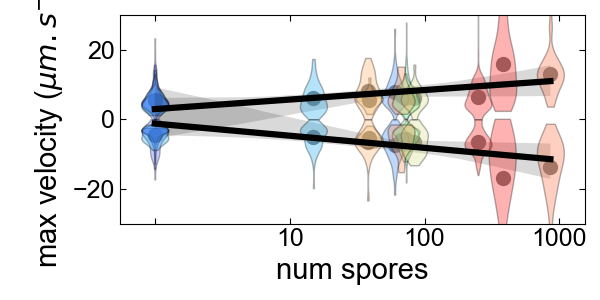

In [16]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots(figsize = (6,3))
# ax2 = ax.twinx()
cmap = mpl.cm.get_cmap("rainbow")
table["log_tot_num_spores"] = np.log10((table["tot_num_spore"]))

table['log_tot_num_spores_correct'] = (table['log_tot_num_spores']>1)*table['log_tot_num_spores']
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
# select = table_speeds.loc[table_speeds["abs_speed"].between(-50, 50)]
select = table.loc[table["speed"]>0]
select = table


# select = table_speeds.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)

n_resamples = 1000
for column in ['speed+','speed-']:
    select = table.loc[table[column].between(-200,200)]

    selectp = select

    mean = selectp.groupby("log_tot_num_spores_correct")[column].mean()
    std = selectp.groupby("log_tot_num_spores_correct")[column].std()
    count = selectp.groupby("log_tot_num_spores_correct")[column].count()
    data = np.array((mean.index,mean))
    x,y = mean.index,mean
    sns.regplot(x = x,
        y = y,ax=ax,scatter=False, color="black")
    # statistic = make_stat(x)
    # std = scipy.stats.bootstrap(data,statistic,
    #                             vectorized = False,
    #                             method="basic",
    #                             n_resamples = n_resamples,
    #                             paired= True).confidence_interval
    # X = sm.add_constant(x, prepend=False)
    # model = sm.OLS(y,X)
    # res = model.fit()
    # a,b = res.params[0],res.params[1]
    # ax.plot(x,np.array(x)*a+b,color = "black")
    # print(a,std)
    ax.scatter(mean.index, mean,color="grey")
    for tot_num_spores in select["log_tot_num_spores"].unique():
        subselect = select.loc[select["log_tot_num_spores"]==tot_num_spores]
        parts = ax.violinplot(subselect[column],[subselect["log_tot_num_spores_correct"].iloc[0]]
                              ,widths = 0.2,showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
            pc.set_edgecolor('black')
    # err =  2*std / np.sqrt(count)
# ax.scatter(table['log_tot_num_spores'],table['speed+'],marker='+',s = 1,alpha = 0.2)
# ax.scatter(table['log_tot_num_spores'],table['speed-'],marker='+',s = 1,alpha = 0.2)
ax.set_xlabel("num spores")
ax.set_ylabel("max velocity ($\mu m.s^{-1}$)")
plt.tight_layout()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
labels = [label if label%10==0 else '' for label in labels]

ax.set_xticklabels(labels)
# ax.set_yscale('symlog')

# path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure4"

# plt.savefig(os.path.join(path_figure,'maxspeed_spore.png'))

ax.set_ylim(-30,30)
plt.savefig(os.path.join(path_figure,'Figure5D.EPS'))
plt.savefig(os.path.join(path_figure,'Figure5D.png'))
# plt.savefig(os.path.join(path_figure,'maxspeed_spore_uncropped.png'))
# plt.savefig(os.path.join(path_figure,'meanspeed_spore.svg'))


C:\Users\coren\AppData\Local\Temp\ipykernel_13844\156646887.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


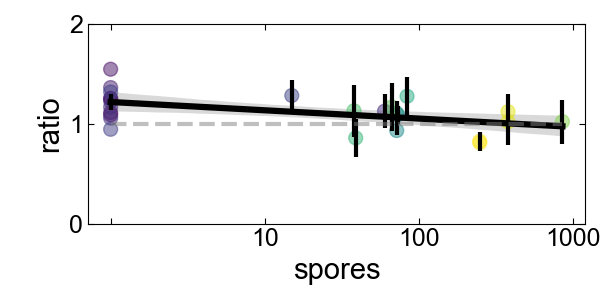

In [17]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots(figsize = (6,3))
cmap = mpl.cm.get_cmap("rainbow")
table_speeds['days_without'] = table_speeds['days']+(table_speeds['unique_id']=="799_20211001")*6
table['days_without'] = table['days']+(table['unique_id']=="799_20211001")*6

table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))

table_speeds['log_tot_num_spores'] = (table_speeds['log_tot_num_spores']>1)*table_speeds['log_tot_num_spores']
table["log_tot_num_spores"] = np.log10((table["tot_num_spore"]))

table['log_tot_num_spores'] = (table['log_tot_num_spores']>1)*table['log_tot_num_spores']

select = table.loc[abs(table["ratio"]).between(0,10)]

n_resamples = 1000
selectp = select

mean = selectp.groupby("csv_id")["ratio"].median()
# std = selectp.groupby("csv_id")["ratio"].std()
# count = selectp.groupby("csv_id")["ratio"].count()
mean_spore = selectp.groupby("csv_id")["log_tot_num_spores"].mean()
data = np.array((mean_spore,mean))
x,y = mean_spore,mean
# ax.scatter(select["days_without"],select['ratio'])
# statistic = make_stat(x)
# ci = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).confidence_interval
# X = sm.add_constant(x, prepend=False)
# model = sm.OLS(y,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
sns.regplot(x = x,
    y = y,ax=ax,scatter=False, color="black")
ax.scatter(mean_spore, mean,c=selectp.groupby("csv_id")["days_without"].mean(),alpha = 0.5)
mean_spore = selectp.groupby("log_tot_num_spores")["ratio"].median()
std = selectp.groupby("log_tot_num_spores")["ratio"].std()
count = selectp.groupby("log_tot_num_spores")["ratio"].count()
# ax.plot(x,np.array(x)*a+b,color = "black")

ax.errorbar(mean_spore.index, mean_spore,yerr= 2*std/np.sqrt(count),fmt = 'None',color="black")
ax.plot(mean_spore.index, mean_spore*0+1,color="grey",alpha = 0.5,linestyle = '--')

# for tot_num_spores in select["days_without"].unique():
#     subselect = select.loc[select["days_without"]==tot_num_spores]
#     day = subselect["days_without"].iloc[0]
#     parts = ax.violinplot(subselect["ratio"],[day]
#                           ,widths = 1,showextrema=False)
#     for pc in parts['bodies']:
#         pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
#         pc.set_edgecolor('black')


ax.set_xlabel("spores")
ax.set_ylabel("ratio")
ax.set_ylim(0,2)


plt.tight_layout()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
labels = [label if label%10==0 else '' for label in labels]

ax.set_xticklabels(labels)
plt.savefig(os.path.join(path_figure,'ratio_spore.png'))


C:\Users\coren\AppData\Local\Temp\ipykernel_13844\3843294183.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


[Text(-1.0, 0, '0'),
 Text(0.0, 0, ''),
 Text(1.0, 0, '10'),
 Text(2.0, 0, '100'),
 Text(3.0, 0, '1000'),
 Text(4.0, 0, '10000')]

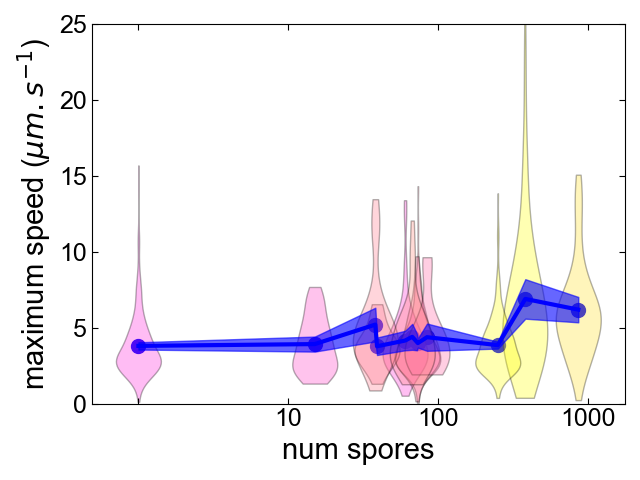

In [18]:
import ast
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots()
# ax2 = ax.twinx()
cmap = mpl.cm.get_cmap("spring")

select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
mean = select.groupby("log_tot_num_spores")["mean_speed+"].mean()
std = select.groupby("log_tot_num_spores")["mean_speed+"].std()
count = select.groupby("log_tot_num_spores")["mean_speed+"].count()

ax.plot(mean.index, mean,color="blue")
ax.scatter(mean.index, mean,color="blue")
for tot_num_spores in select["log_tot_num_spores"].unique():
    subselect = select.loc[select["log_tot_num_spores"]==tot_num_spores]
    parts = ax.violinplot(subselect["mean_speed+"],[subselect["log_tot_num_spores"].iloc[0]]
                          ,widths = 0.3,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cmap(np.mean(subselect['days'])/20))
        pc.set_edgecolor('black')
err =  2*std / np.sqrt(count)
ax.fill_between(mean.index, mean-err, mean+err,color="blue",alpha = 0.6)

# ax.errorbar(3 * mean.index + 1.5, mean, std / np.sqrt(count),color="blue")
ax.set_xlabel("num spores")
ax.set_ylabel("maximum speed ($\mu m.s^{-1}$)")
y = "day"
table_group = time_plate_info.set_index('unique_id').copy()


# ax.tick_params(axis='y', colors='blue')
ax.set_ylim(0,25)
# ax2.tick_params(axis='y', colors='red')
plt.tight_layout()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(10**(ast.literal_eval(label.replace('−','-')))) for label in labels]
labels = [label if label%10==0 else '' for label in labels]

ax.set_xticklabels(labels)
# path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure4"
# plt.savefig(os.path.join(path_figure,'Figure4Emaxspeed_spore.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Emaxspeed_spore.EPS'))
# plt.savefig(os.path.join(path_figure,'maxspeed_spore.png'))

C:\Users\coren\AppData\Local\Temp\ipykernel_4628\3412563020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subselect["mean_speed+"] = subselect["mean_speed+"].fillna(subselect["speed+"])


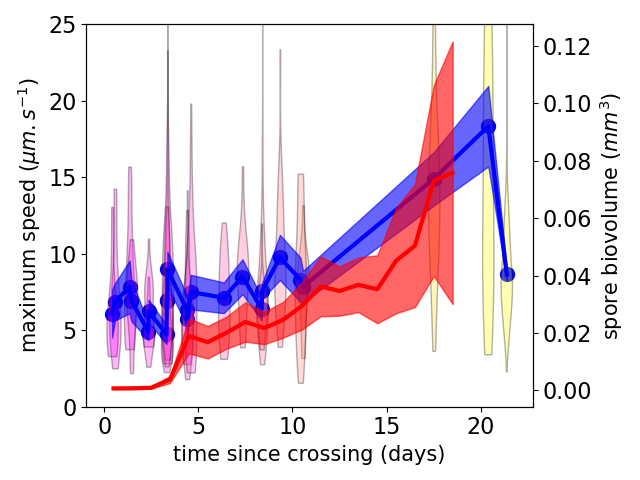

In [68]:
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots()
ax2 = ax.twinx()
cmap = mpl.cm.get_cmap("spring")

# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
mean = select.groupby("days")["speed"].mean()
std = select.groupby("days")["speed"].std()
count = select.groupby("days")["speed"].count()
# ax.plot(2**mean.index, mean,color="blue")
# ax.scatter(2**mean.index, mean,color="blue")
# # for tot_num_spores in select["log_tot_num_spores"].unique():
# #     subselect = select.loc[select["log_tot_num_spores"]==tot_num_spores]
# #     ax.violinplot(subselect["speed"],[2**subselect["log_tot_num_spores"].iloc[0]],widths = 100)
# err =  2*std / np.sqrt(count)
# ax.fill_between(2**mean.index, mean-err, mean+err,color="blue",alpha = 0.6)
ax.plot(mean.index, mean,color="blue")
ax.scatter(mean.index, mean,color="blue")
for tot_num_spores in select["days"].unique():
    subselect = select.loc[select["days"]==tot_num_spores]
    parts = ax.violinplot(subselect["speed"],[subselect["days"].iloc[0]]
                          ,widths = 0.6,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cmap(np.mean(subselect['days'])/20))
        pc.set_edgecolor('black')
err =  2*std / np.sqrt(count)
ax.fill_between(mean.index, mean-err, mean+err,color="blue",alpha = 0.6)

# ax.errorbar(3 * mean.index + 1.5, mean, std / np.sqrt(count),color="blue")
ax.set_ylabel("maximum speed ($\mu m.s^{-1}$)")
y = "spore_volume_mm3"

# for unique_id in time_plate_info['unique_id'].unique():
#     select = time_plate_info.loc[time_plate_info['time_since_begin_h']<450]
#     select = select.loc[select['unique_id']==unique_id]
#     select = select.loc[select[y]>0]
#     select = select.sort_values('time_since_begin_h')
#     if len(select)>0:
#         ax2.plot(select["time_since_begin_h"]/24,select[y]-select[y].iloc[0],label=unique_id,alpha = 0.2)

mini = time_plate_info.groupby('unique_id')[y].min()
maxi = time_plate_info.groupby('unique_id')[y].max()

table_group = time_plate_info.set_index('unique_id').copy()
table_group['mini']= mini
table_group['spore_reduced'] = table_group[y]-table_group['mini']
table_group['maxi']= maxi
table_group = table_group.loc[table_group['maxi']>0]
data = table_group.groupby('day')["spore_reduced"].mean()
datastd = table_group.groupby('day')["spore_reduced"].std()
datacount = table_group.groupby('day')["spore_reduced"].count()
lim = 19
datastd = datastd.loc[data.index<lim]
datacount = datacount.loc[data.index<lim]
data = data.loc[data.index<lim]

err = 2*datastd/np.sqrt(datacount)
ax2.fill_between(data.index+0.5, data-err, data+err,color="red",alpha = 0.6)

ax2.plot(data.index+0.5,data,color="red")
# ax.set_yscale('log')
# ax.legend()
ax.set_xlabel('time since crossing (days)')
ax2.set_ylabel('spore biovolume ($mm^{3}$)')
ax.set_ylim(0,25)
# ax2.tick_params(axis='y', colors='red')
plt.tight_layout()
plt.savefig(os.path.join(path_figure,'maxspeed_time.png'))

C:\Users\coren\AppData\Local\Temp\ipykernel_20352\2798469291.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


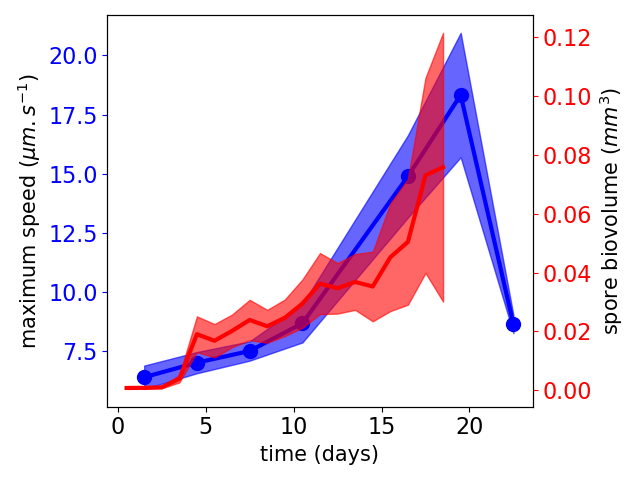

In [430]:
time_plate_info["spore_volume_mm3"]=time_plate_info["spore_volume"]/1e9
fig, ax = plt.subplots()
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
mean = select.groupby("3days")["speed"].mean()
std = select.groupby("3days")["speed"].std()
count = select.groupby("3days")["speed"].count()
ax.plot(num_day * mean.index + num_day/2, mean,color="blue")
ax.scatter(num_day * mean.index + num_day/2, mean,color="blue")

err =  2*std / np.sqrt(count)
ax.fill_between(num_day * mean.index + num_day/2, mean-err, mean+err,color="blue",alpha = 0.6)

# ax.errorbar(3 * mean.index + 1.5, mean, std / np.sqrt(count),color="blue")
ax.set_xlabel("time (days)")
ax.set_ylabel("maximum speed ($\mu m.s^{-1}$)")
ax2 = ax.twinx()
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
# ax2.scatter(table['days'],table['tot_num_spore'])
y = "spore_volume_mm3"

# for unique_id in time_plate_info['unique_id'].unique():
#     select = time_plate_info.loc[time_plate_info['time_since_begin_h']<450]
#     select = select.loc[select['unique_id']==unique_id]
#     select = select.loc[select[y]>0]
#     select = select.sort_values('time_since_begin_h')
#     if len(select)>0:
#         ax2.plot(select["time_since_begin_h"]/24,select[y]-select[y].iloc[0],label=unique_id,alpha = 0.2)

mini = time_plate_info.groupby('unique_id')[y].min()
maxi = time_plate_info.groupby('unique_id')[y].max()

table_group = time_plate_info.set_index('unique_id').copy()
table_group['mini']= mini
table_group['spore_reduced'] = table_group[y]-table_group['mini']
table_group['maxi']= maxi
table_group = table_group.loc[table_group['maxi']>0]
data = table_group.groupby('day')["spore_reduced"].mean()
datastd = table_group.groupby('day')["spore_reduced"].std()
datacount = table_group.groupby('day')["spore_reduced"].count()
lim = 19
datastd = datastd.loc[data.index<lim]
datacount = datacount.loc[data.index<lim]
data = data.loc[data.index<lim]

err = 2*datastd/np.sqrt(datacount)
ax2.fill_between(data.index+0.5, data-err, data+err,color="red",alpha = 0.6)

ax2.plot(data.index+0.5,data,color="red")
# ax.set_yscale('log')
# ax.legend()
ax2.set_xlabel('time (days)')
ax2.set_ylabel('spore biovolume ($mm^{3}$)')

# ax.set_xlim(0, 20)
# ax2.set_yscale('log')
# ax.set_yscale('log')
# plt.legend()
plt.tight_layout()
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure4"
# plt.savefig(os.path.join(path_figure,'Figure4E.svg'))
plt.savefig(os.path.join(path_figure,'maxspeed_time.png'))

In [19]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_between"
paths_bet = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table_bet = pd.DataFrame()
for path in paths_bet:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table_bet = pd.concat([table_bet,new])
table_bet['days'] = table_bet['time_since_crossing']/pd.Timedelta(days=1)
table_bet["days"] = table_bet["time_since_crossing"] / pd.Timedelta(days=1)
table_bet["3days"] = (table_bet["time_since_crossing"] / pd.Timedelta(days=3)).astype(int)
table_bet["days_since_first_image"] = table_bet["days"] - table_bet.groupby("unique_id")[
    "days"
].transform("min")
table_bet["abs_speed-"] = -table_bet["speed-"]

table_bet["speed"] = table_bet[["speed+", "abs_speed-"]].max(1)
table_bet["lengthdm"] = (np.log2((table_bet["tot_length"])) / 2).astype(int) * 2
table_bet["log_tot_num_spores"] = (np.log((table_bet["tot_num_spore"]))).astype(int)

In [20]:
path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds_bet = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths_bet):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    table_loc['csv_id'] = path
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['normalized_random_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['normalized_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['betweenness'] = table_loc['betweenness'].iloc[j]
            
            subtable['random_betweenness'] = table_loc['random_betweenness'].iloc[j]
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            
            

            table_speeds_bet = pd.concat([table_speeds_bet,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
# table_speeds_bet["log_tot_num_spores"] = np.log10((table_speeds_bet["tot_num_spore"]))
table_speeds_bet["abs_speed"] = abs(table_speeds_bet['speed']) 
table_speeds_bet = table_speeds_bet.set_index(['csv_id','kymo_id'])
table_bet = table_bet.set_index(['csv_id','kymo_id'])

In [21]:
speedp = table_speeds_bet.loc[table_speeds_bet['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed+'] = mean_speed
speedp = table_speeds_bet.loc[table_speeds_bet['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed-'] = mean_speed
mean_speed = table_speeds_bet.groupby(['csv_id','kymo_id'])['abs_speed'].mean()
table_bet['mean_speed_abs'] = mean_speed
table_bet["mean_speed+"] = table_bet["mean_speed+"].fillna(table_bet["speed+"])
table_bet["mean_speed-"] = table_bet["mean_speed-"].fillna(table_bet["speed-"])
table_bet["mean_speed_abs"] = table_bet["mean_speed_abs"].fillna(table_bet["speed"])
table_bet['days_without'] = table_bet['days']+(table_bet['unique_id']=="799_20211001")*6
table_speeds_bet['days_without'] = table_speeds_bet['days']+(table_speeds_bet['unique_id']=="799_20211001")*6


In [22]:
table_speeds_bet['log_random_betweenness']=np.log(table_speeds_bet['random_betweenness'])
table_speeds_bet['log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness'])
table_speeds_bet['int_log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness']).astype(int)

In [26]:
table_speeds_bet.to_csv(os.path.join(path_figure,"DataCorentin",'all_speeds_RWBC.csv'))
table_bet.to_csv(os.path.join(path_figure,"DataCorentin",'max_speeds_RWBC.csv'))

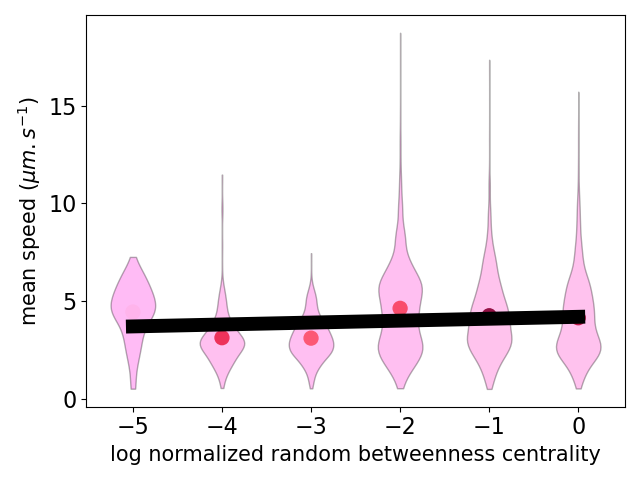

In [22]:
plt.close('all')
fig, ax = plt.subplots()
cmap = mpl.cm.get_cmap("spring")

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ["907_20220321"]

select = table_speeds_bet.loc[table_speeds_bet['normalized_random_betweenness']>0.005]
# select = table_speeds_bet.loc[table_speeds_bet['count+']>10]
# select = select.loc[select['count+']>10]
select = select.loc[select['speed']>0.5]
select['maxi'] = select.groupby('unique_id')['speed'].transform('max')

select['norm_speed'] = select['abs_speed']/select['maxi'] 
select['norm_speed'] = select['abs_speed']


ydata = "int_log_normalized_random_betweenness"
# for i,unique_id in enumerate(selection):
#     select_unique = select.loc[select['unique_id']==unique_id]
#     select_unique = select_unique.sort_values(ydata)
#     # select_unique['norm_speed'] = select_unique['speed']/np.max(select_unique['speed'])
#     # select['norm_speed'] = select_unique['norm_speed']
#     x,y = select_unique[ydata],select_unique['norm_speed']
    
#     # x = np.log10(x)
#     # ax.scatter(x,y,label=unique_id,color = colors[i],alpha = 0.1)
#     # ax.set_xscale('log')
#     X = sm.add_constant(x, prepend=False)
#     model = sm.OLS(y,X)
#     res = model.fit()
#     a,b = res.params[0],res.params[1]
#     ax.plot(x,np.array(x)*a+b,color = colors[i],alpha = 0.3)
    

    
select_unique = select.loc[select['unique_id'].isin(selection)].copy()
select_unique = select_unique.sort_values(ydata)

mean = select_unique.groupby(ydata)["abs_speed"].mean()
std = select_unique.groupby(ydata)["abs_speed"].std()
count = select_unique.groupby(ydata)["abs_speed"].count()
data = np.array((mean.index,mean))
x,y = mean.index,mean

# statistic = make_stat(x)
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.plot(x,np.array(x)*a+b,color = "black",linewidth = 10)
# ax.plot(mean.index, mean,color="blue")
ax.scatter(mean.index, mean,c=select_unique.groupby(ydata)["days"].mean(),cmap="Reds")
for centrality in select_unique[ydata].unique():
    subselect = select_unique.loc[select_unique[ydata]==centrality]
    parts = ax.violinplot(subselect["abs_speed"],[subselect[ydata].iloc[0]]
                          ,widths = 0.5,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cmap(np.mean(subselect['days'])/20))
        pc.set_edgecolor('black')
        
x,y,c = select_unique[ydata],select_unique['norm_speed'],select_unique['days']

# x = np.log10(x)
# ax.scatter(x,y,c=c,cmap=cmap,vmin=0,vmax = 7,label=unique_id,alpha = 0.01)


# ax.legend()
# ax.set_ylim(2,12.5)
# ax.set_yscale('log')

ax.set_xlabel('log normalized random betweenness centrality')
ax.set_ylabel('mean speed ($\mu m.s^{-1}$)')
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmeanspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmeanspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'meanspeed_RWBC.png'))

In [23]:
table_speeds_bet

folder    speed  tot_num_spore  \
csv_id              kymo_id                                                  
201217_Plate09.csv  1        20201217_0835_Plate09  -1.6841              6   
                    1        20201217_0835_Plate09   8.3390              6   
                    1        20201217_0835_Plate09   8.1964              6   
                    1        20201217_0835_Plate09  11.0920              6   
                    1        20201217_0835_Plate09   8.3041              6   
...                                            ...      ...            ...   
220324_Plate907.csv 56       20220325_1423_Plate09  -2.3962             15   
                    57       20220325_1423_Plate09  -1.6209             15   
                    57       20220325_1423_Plate09  -1.6388             15   
                    57       20220325_1423_Plate09  -2.2406             15   
                    57       20220325_1423_Plate09  -1.7689             15   

                                 days     unique_id  \
csv_id              kymo_id                           
201217_Plate09.csv  1        3.357639  139_20201214   
                    1        3.357639  139_20201214   
                    1        3.357639  139_20201214   
                    1        3.357639  139_20201214   
                    1        3.357639  139_20201214   
...                               ...           ...   
220324_Plate907.csv 56       4.599306  907_20220321   
                    57       4.599306  907_20220321   
                    57       4.599306  907_20220321   
                    57       4.599306  907_20220321   
                    57       4.599306  907_20220321   

                             normalized_random_betweenness  \
csv_id              kymo_id                                  
201217_Plate09.csv  1                             0.078355   
                    1                             0.078355   
                    1                             0.078355   
                    1                             0.078355   
                    1                             0.078355   
...                                                    ...   
220324_Plate907.csv 56                            0.127417   
                    57                            0.127417   
                    57                            0.127417   
                    57                            0.127417   
                    57                            0.127417   

                             normalized_betweenness  betweenness  \
csv_id              kymo_id                                        
201217_Plate09.csv  1                      0.078355     0.000006   
                    1                      0.078355     0.000006   
                    1                      0.078355     0.000006   
                    1                      0.078355     0.000006   
                    1                      0.078355     0.000006   
...                                             ...          ...   
220324_Plate907.csv 56                     0.127417     0.000310   
                    57                     0.127417     0.000310   
                    57                     0.127417     0.000310   
                    57                     0.127417     0.000310   
                    57                     0.127417     0.000310   

                             random_betweenness  abs_speed  days_without  \
csv_id              kymo_id                                                
201217_Plate09.csv  1                  0.000226     1.6841      3.357639   
                    1                  0.000226     8.3390      3.357639   
                    1                  0.000226     8.1964      3.357639   
                    1                  0.000226    11.0920      3.357639   
                    1                  0.000226     8.3041      3.357639   
...                                         ...        ...           ...   
220324_Plate9

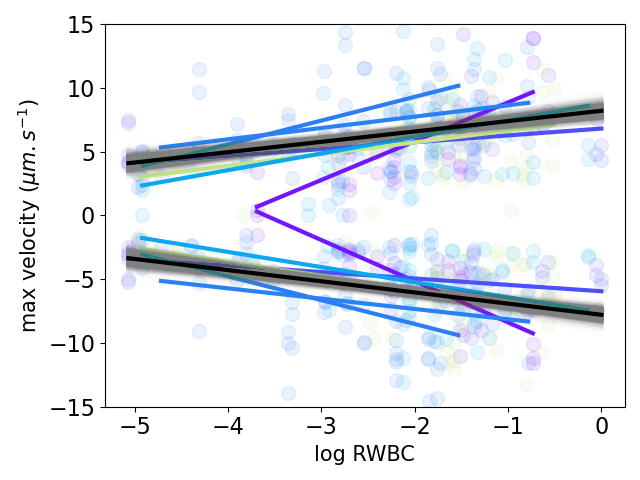

In [27]:
plt.close('all')
cmap = mpl.cm.get_cmap("rainbow")

fig, ax = plt.subplots()
select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
# select = table_bet.loc[table_bet['normalized_betweenness']>0.005]

select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ["907_20220321"]
ydata = "normalized_random_betweenness"
select['maxi'] = select.groupby('unique_id')['speed'].transform('max')

select['norm_speed'] = select['speed']/select['maxi'] 
for y in ['speed-','speed+']:
    select['norm_speed'] = select[y]
    x0 = np.linspace(-5,0,10)

    for i,unique_id in enumerate(selection):

        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        # r = np.sqrt((np.mean(select_unique['days']))/22)
        # c1 = np.array((0.9,0.9,0.2))
        # c2 = np.array((1,0,0))
        # # print((1-r)*c1+r*c2)
        # color = (1-r)*c1+r*c2
        color = cmap((np.mean(select_unique['days_without'])/20))

        x,y = select_unique[ydata],select_unique['norm_speed']

        x = np.log(x)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,label=unique_id,color = color,alpha = 0.1)

        ax.plot(x,np.array(x)*a+b,color = color)

    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)

    x,y,c = select_unique[ydata],select_unique['norm_speed'],np.sqrt(select_unique['days_without'])

    x = np.log(x)
    # ax.scatter(x,y,c=c,cmap=cmap,vmin=0,vmax = 20,label=unique_id,alpha = 0.3)

    x0 = np.linspace(np.min(x),np.max(x),10)
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = "grey", alpha = 0.01)
        return(a)

    data = np.array((x,y))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(x0,np.array(x0)*a+b,color = "black")
# ax.fill_between(x,np.array(x)*(a-2*std)+b, np.array(x)*a+b,color="red",alpha = 0.6)

# ax.legend()
# ax.set_ylim(-15,15)
# ax.set_yscale('log')

ax.set_xlabel('log RWBC')
ax.set_ylabel('max velocity ($\mu m.s^{-1}$)')
plt.tight_layout()

plt.savefig(os.path.join(path_figure,'maxspeed_RWBC_uncropped.png'))
ax.set_ylim(-15,15)
plt.tight_layout()

plt.savefig(os.path.join(path_figure,'maxspeed_RWBC.png'))

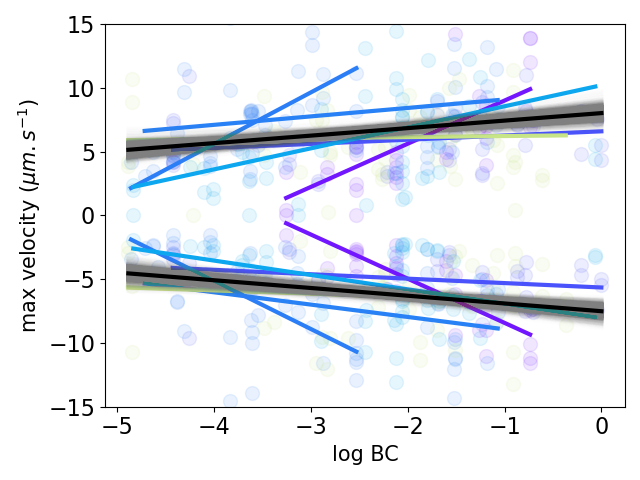

In [29]:
plt.close('all')
fig, ax = plt.subplots()
# select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
select = table_bet.loc[table_bet['normalized_betweenness']>0.005]

select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ["907_20220321"]
ydata = "normalized_betweenness"
select['maxi'] = select.groupby('unique_id')['speed'].transform('max')

select['norm_speed'] = select['speed']/select['maxi'] 
for y in ['speed-','speed+']:
    select['norm_speed'] = select[y]
    x0 = np.linspace(-5,0,10)

    for i,unique_id in enumerate(selection):

        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        # r = np.sqrt((np.mean(select_unique['days']))/22)
        # c1 = np.array((0.9,0.9,0.2))
        # c2 = np.array((1,0,0))
        # # print((1-r)*c1+r*c2)
        # color = (1-r)*c1+r*c2
        color = cmap((np.mean(select_unique['days_without'])/20))

        x,y = select_unique[ydata],select_unique['norm_speed']

        x = np.log(x)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,label=unique_id,color = color,alpha = 0.1)

        ax.plot(x,np.array(x)*a+b,color = color)

    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)

    x,y,c = select_unique[ydata],select_unique['norm_speed'],np.sqrt(select_unique['days_without'])

    x = np.log(x)
    # ax.scatter(x,y,c=c,cmap=cmap,vmin=0,vmax = 20,label=unique_id,alpha = 0.3)

    x0 = np.linspace(np.min(x),np.max(x),10)
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = "grey", alpha = 0.01)
        return(a)

    data = np.array((x,y))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(x0,np.array(x0)*a+b,color = "black")


ax.set_xlabel('log BC')
ax.set_ylabel('max velocity ($\mu m.s^{-1}$)')
plt.tight_layout()

plt.savefig(os.path.join(path_figure,'maxspeed_BC_uncropped.png'))
# plt.savefig(os.path.join(path_figure,'maxspeed_BC_uncropped.png'))

ax.set_ylim(-15,15)
plt.tight_layout()

plt.savefig(os.path.join(path_figure,'maxspeed_BC.png'))
# plt.savefig(os.path.join(path_figure,'maxspeed_BC.svg'))



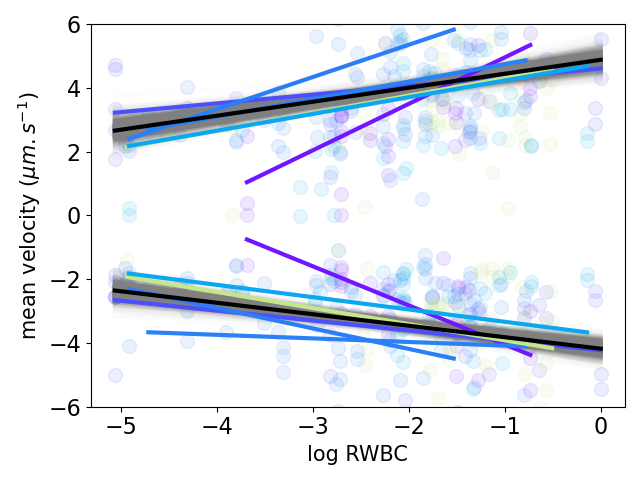

In [31]:
plt.close('all')
fig, ax = plt.subplots()
# select = table_bet.loc[table_bet['normalized_betweenness']>0.005]

select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ["907_20220321"]
ydata = "normalized_random_betweenness"
select['maxi'] = select.groupby('unique_id')['speed'].transform('max')

select['norm_speed'] = select['speed']/select['maxi'] 

for y in ['mean_speed-','mean_speed+']:
    select['norm_speed'] = select[y]
    
    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)
    
    x,y,c = select_unique[ydata],select_unique['norm_speed'],select_unique['days_without']

    x = np.log(x)
    x0 = np.linspace(np.min(x),np.max(x),10)
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = "grey", alpha = 0.01)
        return(a)

    data = np.array((x,y))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    for i,unique_id in enumerate(selection):

        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        # select_unique['norm_speed'] = select_unique['speed']/np.max(select_unique['speed'])
        # select['norm_speed'] = select_unique['norm_speed']
        x,y = select_unique[ydata],select_unique['norm_speed']
        color = cmap((np.mean(select_unique['days_without'])/20))

        x = np.log(x)
        # ax.scatter(x,y,label=unique_id,color = colors[i],alpha = 0.1)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,label=unique_id,color = color,alpha = 0.1)
        
        ax.plot(x,np.array(x)*a+b,color = color,alpha = 1)

    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)
    
    x,y,c = select_unique[ydata],select_unique['norm_speed'],select_unique['days_without']
    x = np.log(x)
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(x0,np.array(x0)*a+b,color = "black")

ax.set_xlabel('log RWBC')
ax.set_ylabel('mean velocity ($\mu m.s^{-1}$)')
plt.tight_layout()
plt.savefig(os.path.join(path_figure,'meanspeed_RWBC_uncropped.png'))
plt.savefig(os.path.join(path_figure,'meanspeed_RWBC_uncropped.svg'))
    # ax.legend()
ax.set_ylim(-6,6)
# ax.set_yscale('log')


plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.png'))
plt.savefig(os.path.join(path_figure,'meanspeed_RWBC.png'))
plt.savefig(os.path.join(path_figure,'meanspeed_RWBC.svg'))

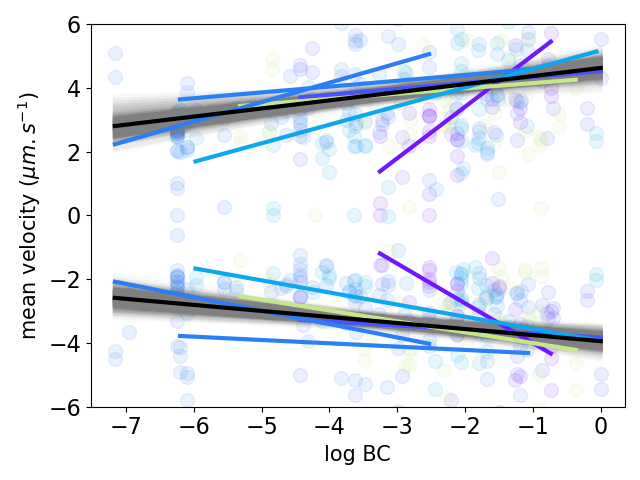

In [78]:
plt.close('all')
fig, ax = plt.subplots()
select = table_bet.loc[table_bet['normalized_betweenness']>0.00005]

# select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ["907_20220321"]
ydata = "normalized_betweenness"
select['maxi'] = select.groupby('unique_id')['speed'].transform('max')

select['norm_speed'] = select['speed']/select['maxi'] 

for y in ['mean_speed-','mean_speed+']:
    select['norm_speed'] = select[y]
    
    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)
    
    x,y,c = select_unique[ydata],select_unique['norm_speed'],select_unique['days_without']

    x = np.log(x)
    x0 = np.linspace(np.min(x),np.max(x),10)
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = "grey", alpha = 0.01)
        return(a)

    data = np.array((x,y))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    for i,unique_id in enumerate(selection):

        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        # select_unique['norm_speed'] = select_unique['speed']/np.max(select_unique['speed'])
        # select['norm_speed'] = select_unique['norm_speed']
        x,y = select_unique[ydata],select_unique['norm_speed']
        color = cmap((np.mean(select_unique['days_without'])/20))

        x = np.log(x)
        # ax.scatter(x,y,label=unique_id,color = colors[i],alpha = 0.1)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,label=unique_id,color = color,alpha = 0.1)
        
        ax.plot(x,np.array(x)*a+b,color = color,alpha = 1)

    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)
    
    x,y,c = select_unique[ydata],select_unique['norm_speed'],select_unique['days']
    x = np.log(x)
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(x0,np.array(x0)*a+b,color = "black")

ax.set_xlabel('log BC')
ax.set_ylabel('mean velocity ($\mu m.s^{-1}$)')
plt.tight_layout()
plt.savefig(os.path.join(path_figure,'meanspeed_BC_uncropped.png'))
    # ax.legend()
ax.set_ylim(-6,6)
# ax.set_yscale('log')


plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.png'))
plt.savefig(os.path.join(path_figure,'meanspeed_BC.png'))

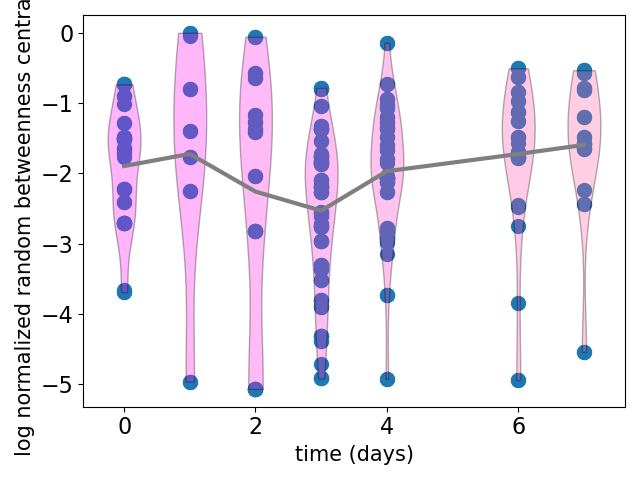

In [55]:
fig, ax = plt.subplots()
table_bet['log_normalized_random_betweenness']=np.log(table_bet['normalized_random_betweenness'])
table_bet['days_int']=table_bet['days'].astype(int)

select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
select = select.loc[select['speed']>0.1]
ax.scatter(select['days_int'],select['log_normalized_random_betweenness'])
ydata = "days_int"
mean = select.groupby('days_int')['log_normalized_random_betweenness'].mean()
for day in select[ydata].unique():
    subselect = select.loc[select[ydata]==day]
    parts = ax.violinplot(subselect["log_normalized_random_betweenness"],[subselect[ydata].iloc[0]]
                          ,widths = 0.5,showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(cmap(np.mean(subselect['days'])/20))
        pc.set_edgecolor('black')
ax.plot(mean.index,mean)
ax.set_ylabel('log normalized random betweenness centrality')
ax.set_xlabel('time (days)')
plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.png'))
plt.savefig(os.path.join(path_figure,'logRWBC_time.png'))

In [62]:
import pandas as pd
import numpy as np
table_bet['max_speed'] = table_bet['speed']
corr = table_bet[['mean_speed_abs','max_speed','normalized_random_betweenness','normalized_betweenness']].corr()
corr.style.background_gradient(cmap='coolwarm')
# plt.savefig(os.path.join(path_figure,'correlations.png'))
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.matshow(corr)
# plt.xticks(range(len(corr.columns)), corr.columns)
# plt.yticks(range(len(corr.columns)), corr.columns)

,mean_speed_abs,max_speed,normalized_random_betweenness,normalized_betweenness
mean_speed_abs,1.000000,0.607736,0.207371,0.162465
max_speed,0.607736,1.000000,0.231521,0.186158
normalized_random_betweenness,0.207371,0.231521,1.000000,0.870205
normalized_betweenness,0.162465,0.186158,0.870205,1.000000
